# COMP9517 Group Project

### Data Exploration & Analysis

First we will do some preliminary data exploration to understand what is contained in this dataset. Since this is a novel dataset, there is no guarantee that the data is complete, or that every single photo contains at least one head, carapace, and fin. 

In [1]:
from pycocotools.coco import COCO

# Load in annotations file
annotation_file = 'turtles-data/data/annotations.json'
coco = COCO(annotation_file)
print("\n----------------- Dataset Information -----------------\n")

# Count number of images for our dataset
image_ids = coco.getImgIds()
num_images = len(image_ids)
print("Number of images in dataset: ", num_images)

# Identify the number of categories in our dataset
coco.loadCats(coco.getCatIds())
category_ids = coco.loadCats(coco.getCatIds())
categories = {category['id']: category['name'] for category in category_ids}

# Ensure there are no additonal categories that we did not expect
expected_categories = {'turtle', 'head', 'flipper'}
if set(categories.values()) != expected_categories:
    raise ValueError(f"Unexpected categories in dataset {categories}")
else:
    print("\nAll categories are expected in dataset")

loading annotations into memory...
Done (t=3.69s)
creating index...
index created!

----------------- Dataset Information -----------------

Number of images in dataset:  8729

All categories are expected in dataset


In [2]:
cat_ids = coco.getCatIds()
categories = coco.loadCats(cat_ids)

# Print out each category's information and order
for category in categories:
    print(f"ID: {category['id']}, Name: {category['name']}")

ID: 1, Name: turtle
ID: 2, Name: flipper
ID: 3, Name: head


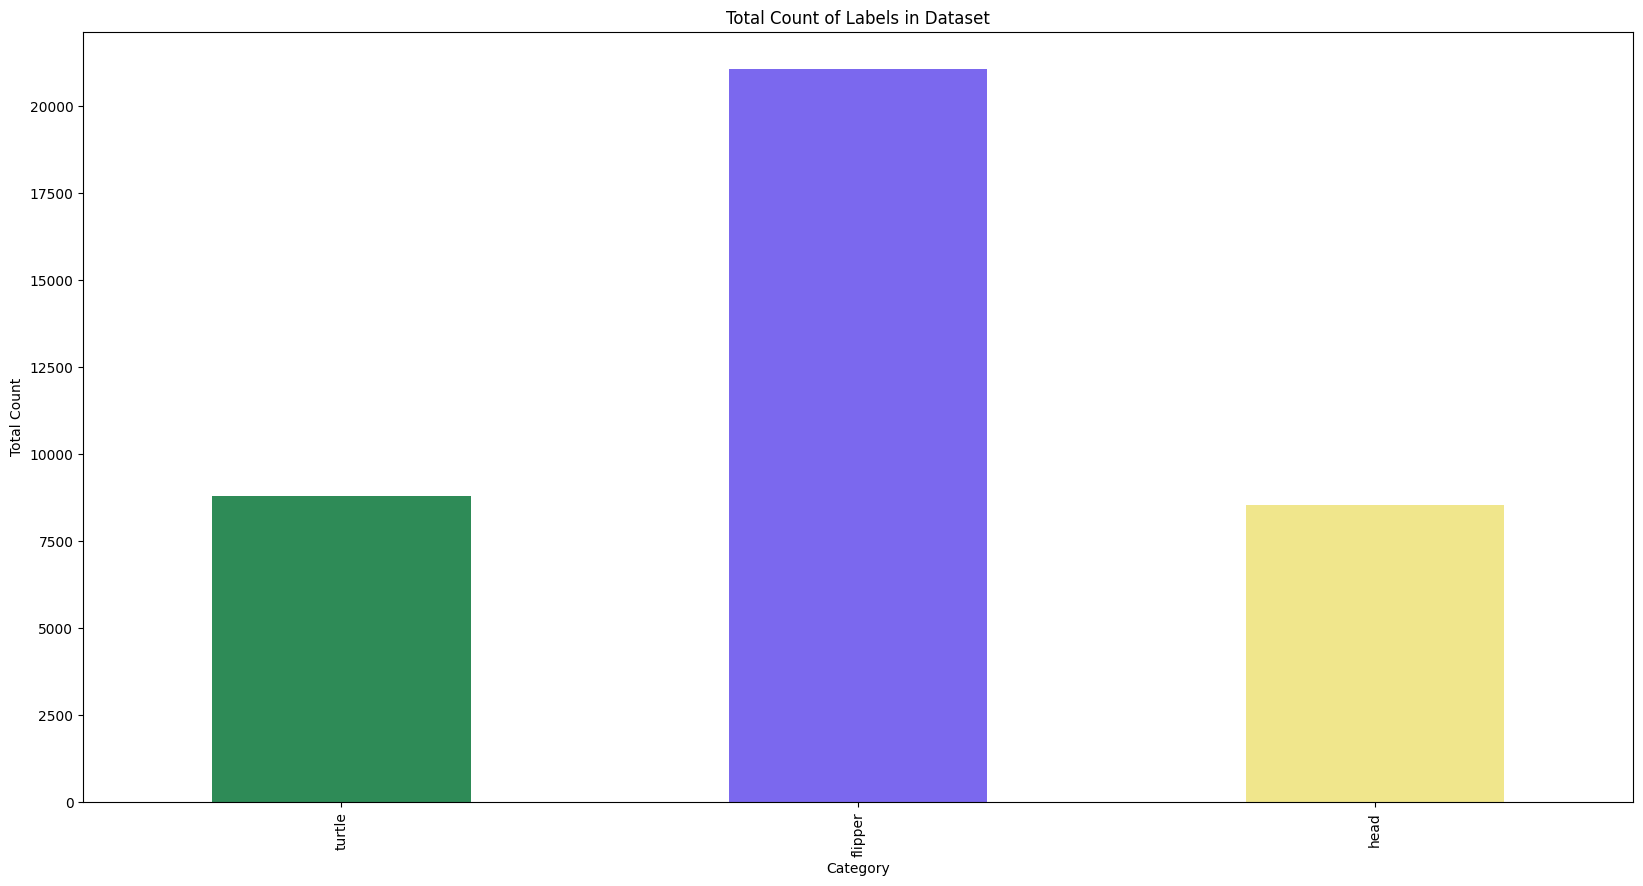

c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

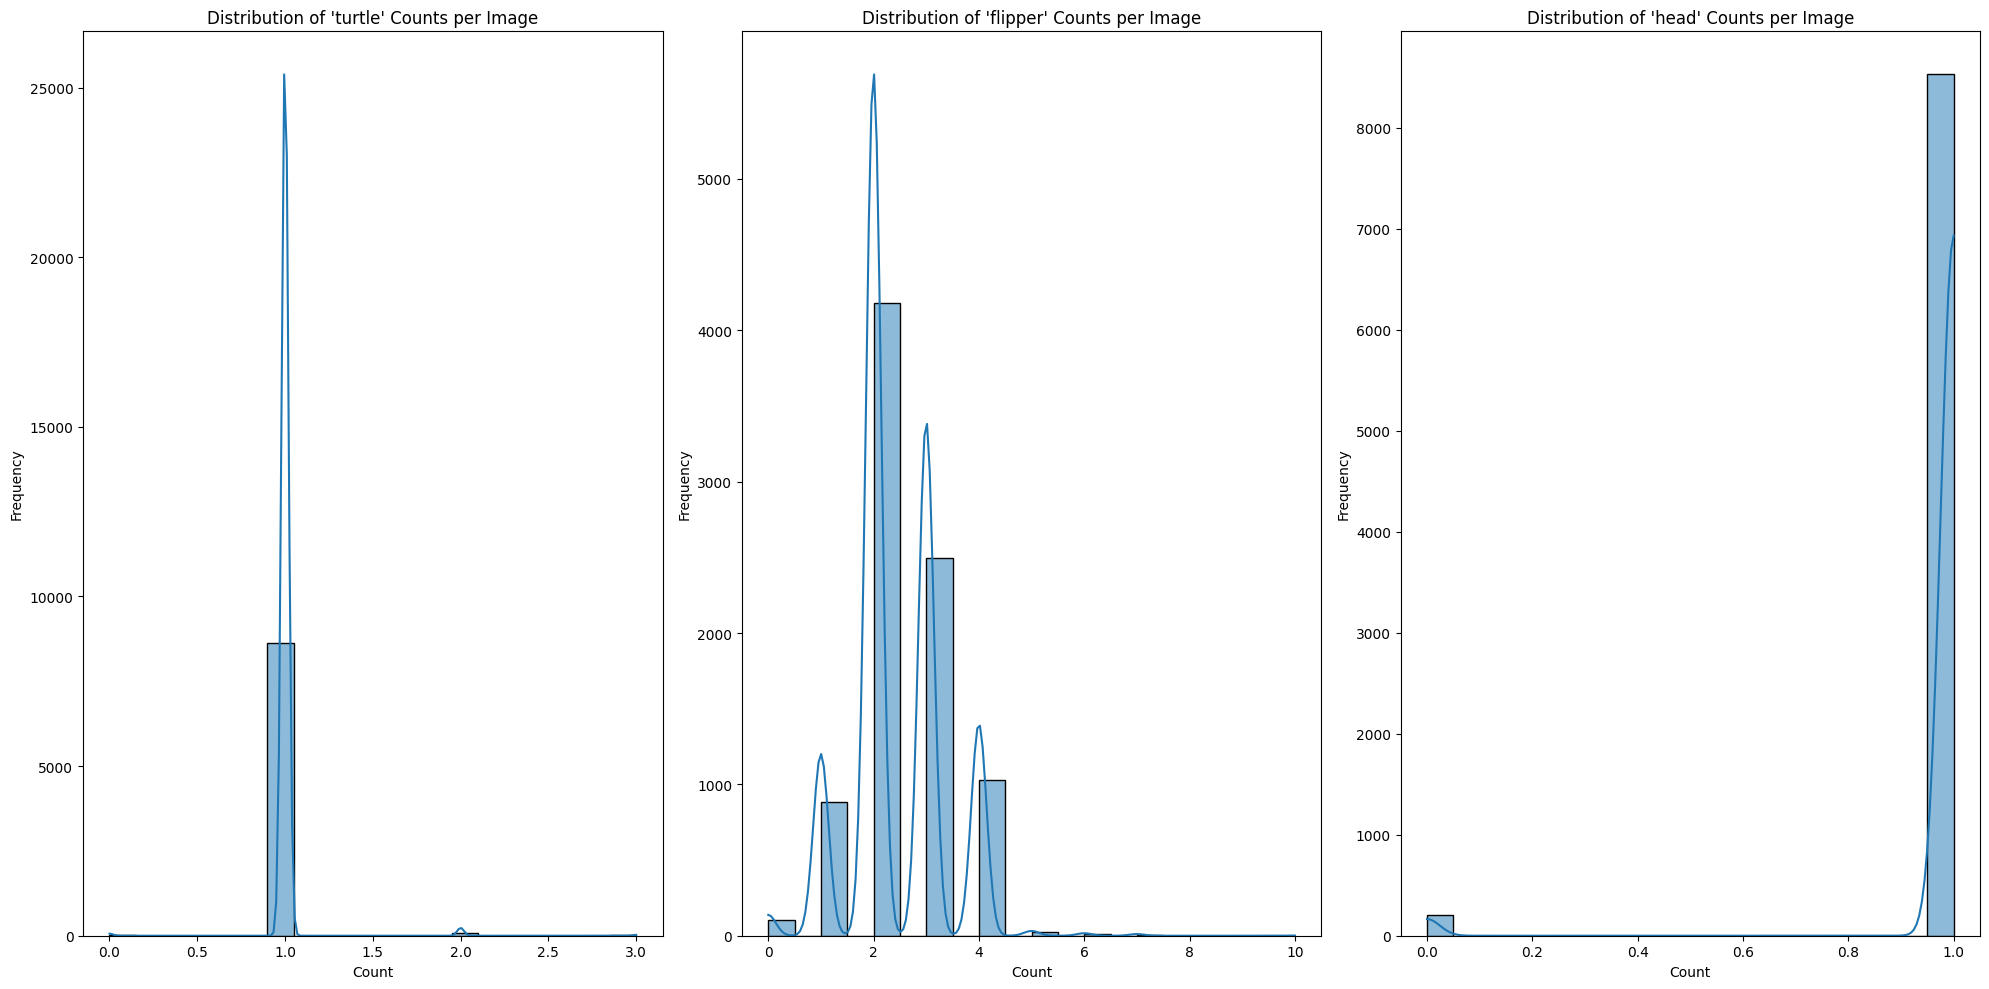

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


category_names = ["turtle", "flipper", "head"]  # Mistake found ! Make sure to maintain order
cat_ids = coco.getCatIds(catNms=category_names)

# Create a dictionary to count how many counts of each category there are in each image
category_counts = {'image_id': [], 'turtle': [], 'flipper': [], 'head': []}

# Loop over each image
img_ids = coco.getImgIds()
for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)

    # Append the current image ID
    category_counts["image_id"].append(img_id)

    # Count number of each category for current image ID
    category_counts["turtle"].append(
        sum(ann["category_id"] == cat_ids[0] for ann in anns)
    )
    category_counts["flipper"].append(
        sum(ann["category_id"] == cat_ids[1] for ann in anns)
    )
    category_counts["head"].append(
        sum(ann["category_id"] == cat_ids[2] for ann in anns)
    )

# Convert to dataframe
category_counts_df = pd.DataFrame(category_counts)
category_sums = category_counts_df[["turtle", "flipper", "head"]].sum()

# Totals for each category
plt.figure(figsize=(20, 10))
category_sums.plot(kind="bar", color=["seagreen", "mediumslateblue", "khaki"])
plt.title("Total Count of Labels in Dataset")
plt.xlabel("Category")
plt.ylabel("Total Count")
plt.show()

plt.figure(figsize=(20, 10))
for i, category in enumerate(["turtle", "flipper", "head"]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(category_counts_df[category], kde=True, bins=20)
    plt.title(f"Distribution of '{category}' Counts per Image")
    plt.xlabel("Count")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Dataset contains 8729 images. Some images may not contain a turtle, head, or flipper so we will investigate these files manually.

In [4]:
required_categories = ["turtle", "flipper", "head"]
cat_ids = coco.getCatIds(catNms=required_categories)
cat_ids_map = dict(zip(category_names, cat_ids))

missing_labels_images = {category: 0 for category in required_categories}
img_ids = coco.getImgIds()

for img_id in img_ids:
    missing_categories = []
    for category, cat_id in cat_ids_map.items():
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
        if not ann_ids:
            missing_categories.append(category)

    for category in missing_categories:
        missing_labels_images[category] += 1

# Report results
for category, count in missing_labels_images.items():
    print(f"Number of images missing '{category}' label: {count}\n")

Number of images missing 'turtle' label: 20

Number of images missing 'flipper' label: 101

Number of images missing 'head' label: 203



In [122]:
# Load in the ones without a turtle to investigate what is going on with the missing labels

missing_turtle_img_ids = []
for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["turtle"])
    if not ann_ids:
        missing_turtle_img_ids.append(img_id)

In [126]:
import numpy as np
from PIL import Image

def load_images(missing_part_images_ids):
    for image_id in missing_part_images_ids:

        # Debug missing images
        try:
            img = coco.loadImgs(image_id)[0]
        except TypeError:
            print(f"This image ID is missing: {image_id}")
            continue

        image = np.array(Image.open(f"turtles-data/data/{img['file_name']}"))
        plt.figure(figsize=(20, 10))

        # Original
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title("Original Image")

        # Annotations
        plt.subplot(1, 3, 2)
        plt.imshow(image)
        cat_ids = coco.getCatIds()
        ann_ids = coco.getAnnIds(imgIds=img["id"], catIds=cat_ids, iscrowd=None)
        anns = coco.loadAnns(ann_ids)
        coco.showAnns(anns)
        plt.axis("off")
        plt.title("Annotations")

        # Masked
        plt.subplot(1, 3, 3)
        mask = np.zeros((img["height"], img["width"]), dtype=np.uint8)
        for ann in anns:
            mask += coco.annToMask(ann)
        plt.imshow(mask, cmap="plasma")
        plt.axis("off")
        plt.title("Masked")
        plt.tight_layout()
        plt.show()

In [ ]:
""" 
# NOTE! Unload these cells before pushing to git to avoid making the file too large.
# Clear the output of the cells above before pushing to git.
"""

load_images(missing_turtle_img_ids)

Based on the images above, the dataset quality is quite concerning. We will do the same for the other datasets which are missing labels with the exact same method as above.

In [128]:
# Load in files again in case of lost or incorrect reference
# annotation_file = "turtles-data/data/annotations.json"
# coco = COCO(annotation_file)
image_ids = coco.getImgIds()

missing_head_image_ids = []
missing_flipper_image_ids = []

for img_id in image_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["head"])
    if not ann_ids:
        missing_head_image_ids.append(img_id)

    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["flipper"])
    if not ann_ids:
        missing_flipper_image_ids.append(img_id)

print(f"Number of images missing 'head' label: {len(missing_head_image_ids)}")
print(f"Number of images missing 'flipper' label: {len(missing_flipper_image_ids)}")

Number of images missing 'head' label: 203
Number of images missing 'flipper' label: 101


In [ ]:
""" 
# NOTE! Unload these cells before pushing to git to avoid making the file too large.
# Clear the output of the cells above before pushing to git.
# Since there are 304 images missing the head label, this is extra important!
"""

load_images(missing_head_image_ids)
load_images(missing_flipper_image_ids)

### Dataset Cleanup & Re-validation

Here we will directly edit and delete the unnecessary files of the COCO dataset. Based on the analysis done in the section above, we will only delete the 20 images that are labelled with no turtle as every single datapoint there have quite significant errors in their annotation.

In [8]:
# We will need to refetch all references to the COCO objects as well as the imageIDs of the errornous dataset
# images... Please make sure you run this on your own machine prior to training the model.

import json
import os
from pycocotools.coco import COCO

# Load in annotations file
annotation_file = "turtles-data/data/annotations.json"
coco = COCO(annotation_file)
print("\n----------------- Before Cleanup -----------------\n")

# Count number of images for our dataset
image_ids = coco.getImgIds()
num_images = len(image_ids)
print("Number of images in dataset: ", num_images) # 8729 -> 8709

# Identify the number of categories in our dataset
category_ids = coco.loadCats(coco.getCatIds())
categories = {category["id"]: category["name"] for category in category_ids}

# Find the ones that are missing the turtle label
missing_turtle_img_ids = []
for img_id in image_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["turtle"])
    if not ann_ids:
        missing_turtle_img_ids.append(img_id)
print(f"Number of images missing 'turtle' label: {len(missing_turtle_img_ids)}")

print(f"\nRemoving these images from the dataset...\n")

# Begin the purge
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Remove images and annotations from JSON
coco_data['images'] = [img for img in coco_data['images'] if img['id'] not in missing_turtle_img_ids]
coco_data['annotations'] = [ann for ann in coco_data['annotations'] if ann['image_id'] not in missing_turtle_img_ids]

# Save as a new updated JSON file
with open("turtles-data/data/updated_annotations.json", 'w') as f:
    json.dump(coco_data, f)
print("\n----------------- After Cleanup -----------------\n")
print("Updated annotations saved to 'turtles-data/data/updated_annotations.json'. Please use this from now on!")

# Delete image files
images_path = "turtles-data/data/"
for img_id in missing_turtle_img_ids:
    img_info = coco.loadImgs([img_id])[0]
    img_file_path = os.path.join(images_path, img_info['file_name'])
    if os.path.exists(img_file_path):
        os.remove(img_file_path)
        print(f"[SUCCESS]: Deleted image file: {img_file_path}")
    else:
        print(f"[ERROR!]: Image file not found: {img_file_path}")

print("All files without turtles have been deleted successfully!")

# Load in new annotations as validation
annotation_file = "turtles-data/data/updated_annotations.json"
coco = COCO(annotation_file)
image_ids = coco.getImgIds()
num_images = len(image_ids)
print("Number of images in dataset: ", num_images)

# Find the ones that are missing the turtle label
missing_turtle_img_ids = []
for img_id in image_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["turtle"])
    if not ann_ids:
        missing_turtle_img_ids.append(img_id)
print(f"Number of images missing 'turtle' label: {len(missing_turtle_img_ids)}")

loading annotations into memory...
Done (t=4.01s)
creating index...
index created!

----------------- Before Cleanup -----------------

Number of images in dataset:  8729
Number of images missing 'turtle' label: 20

Removing these images from the dataset...


----------------- After Cleanup -----------------

Updated annotations saved to 'turtles-data/data/updated_annotations.json'. Please use this from now on!
[SUCCESS]: Deleted image file: turtles-data/data/images/t099/YRcDEhpcgy.JPG
[SUCCESS]: Deleted image file: turtles-data/data/images/t102/wFLjWpiUvj.jpeg
[SUCCESS]: Deleted image file: turtles-data/data/images/t221/LDRANGMdHp.JPG
[SUCCESS]: Deleted image file: turtles-data/data/images/t221/wXxaQqJIQN.JPG
[SUCCESS]: Deleted image file: turtles-data/data/images/t231/BqCROAbeaX.jpg
[SUCCESS]: Deleted image file: turtles-data/data/images/t243/UHJWFhnlIg.JPG
[SUCCESS]: Deleted image file: turtles-data/data/images/t322/SUlvTiCoSI.JPG
[SUCCESS]: Deleted image file: turtles-data/data/ima